# **Ejercicio Semana 10: Reconstruir puntos 3D de varias imágenes**

Visión por Computador

Ingeniería Agronómica

Monica Paola Vargas Tirado

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2 as cv
import glob
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

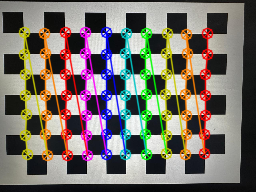

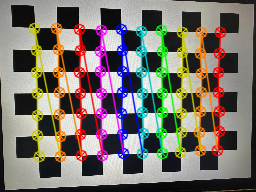

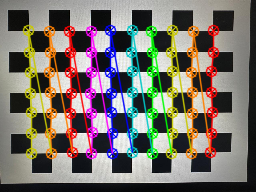

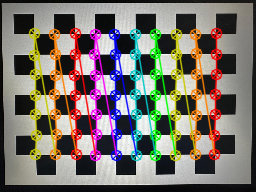

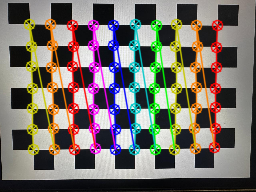

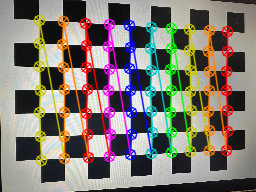

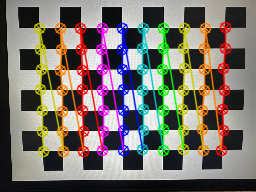

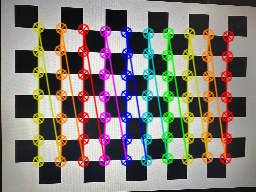

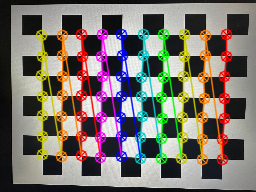

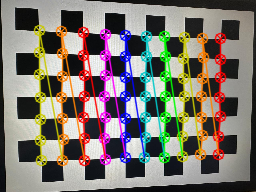

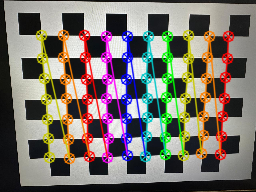

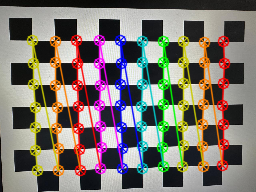

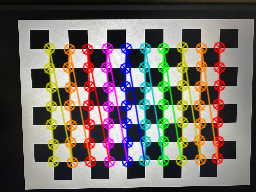

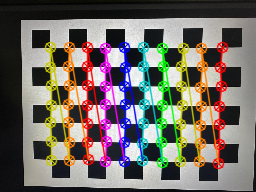

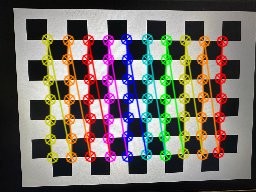

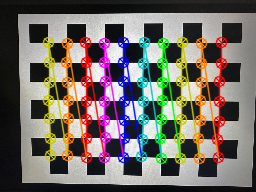

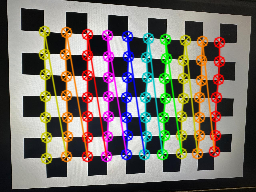

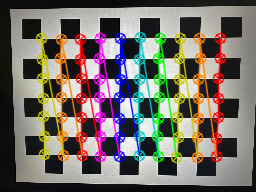

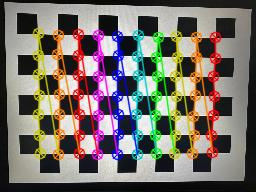

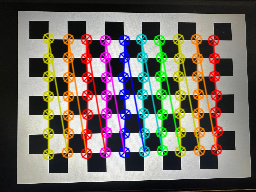

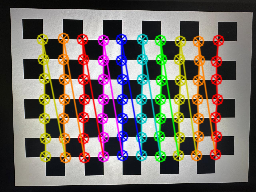

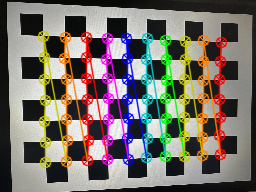

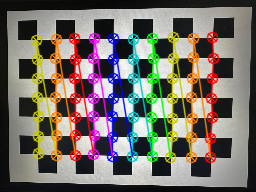

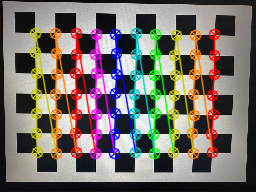

In [3]:
# Criterios de terminación
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Preparar puntos de objeto, como (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*10,3), np.float32)
objp[:,:2] = np.mgrid[0:10,0:7].T.reshape(-1,2)

# Matrices para almacenar puntos de objetos y puntos de imágenes de todas las imágenes.
objpoints = [] # Punto 3d en el espacio del mundo real.
imgpoints = [] # Puntos 2d en el plano de la imagen.

images = glob.glob('/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/Dataset/Tablero/*.jpeg')

for fname in images:
 img = cv.imread(fname)
 img = cv.resize(img, (0,0), fx=0.2, fy=0.2)
 gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

 # Encuentra las esquinas del tablero de ajedrez.
 ret, corners = cv.findChessboardCorners(gray, (7,10), None)

 # Si lo encuentra, agregue puntos de objeto, puntos de imagen (después de refinarlos)
 if ret == True:
  objpoints.append(objp)
  corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
  imgpoints.append(corners2)

 # Dibuja y muestra las esquinas.
 cv.drawChessboardCorners(img, (7,10), corners2, ret)
 cv2_imshow(img)
 cv.waitKey(500)

In [4]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)
print(dist)

[[5.72667872e+03 0.00000000e+00 1.51184804e+02]
 [0.00000000e+00 5.18837052e+02 7.39212420e+01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-7.73740311e+02 -2.18625701e+04  3.11642578e+01  1.50482155e+00
  -3.69213622e+01]]


In [5]:
# Definir las constantes de la cámara
FX = 5.72527909e+03
FY = 5.18669153e+02
CX = 1.51185656e+02
CY = 7.39210408e+01

# Lista para almacenar las coordenadas de los puntos de cada par de imágenes
coordenadas_puntos = []


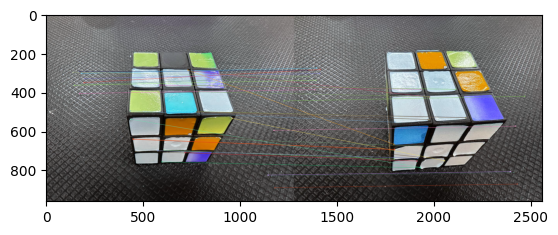

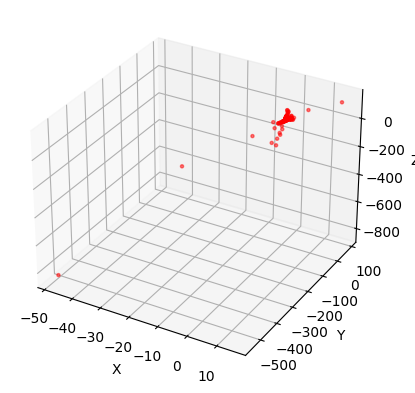

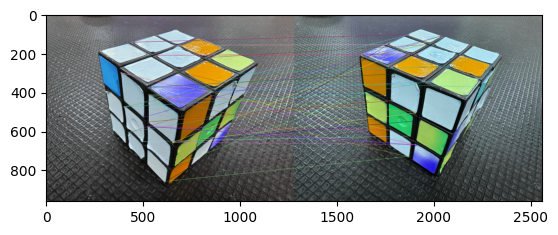

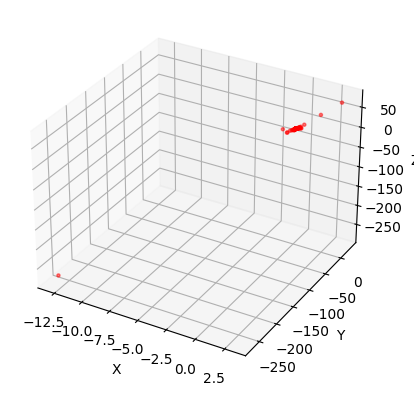

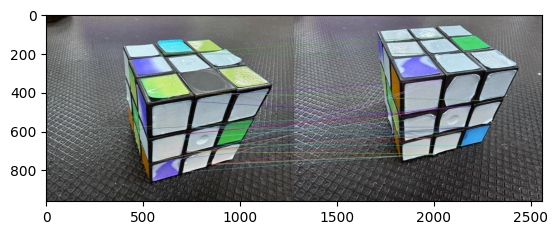

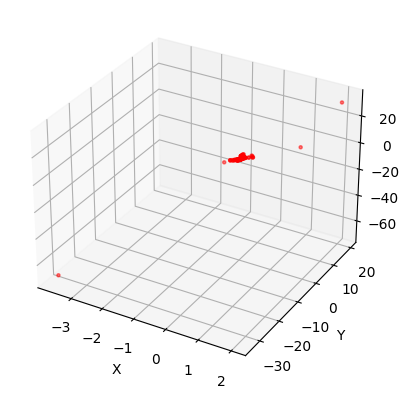

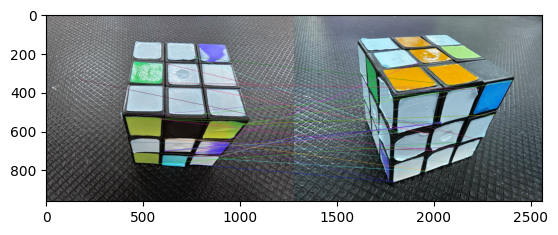

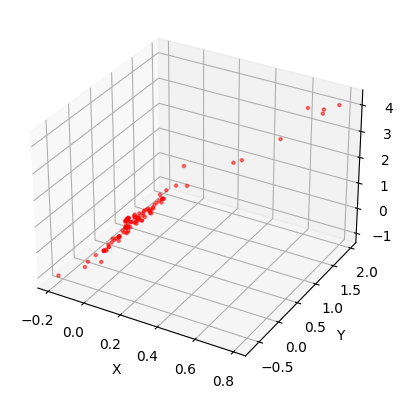

In [7]:
# Define la función para dibujar y mostrar los emparejamientos
def draw_matches(img1, kp1, img2, kp2, matches, num_matches=40):
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:num_matches], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_matches)
    plt.show()

# Lista para almacenar las coordenadas 3D de los puntos
coordenadas_puntos = []

# Realiza el proceso 4 veces (para 8 imágenes)
for i in range(1, 5):
    img1 = cv2.imread(f'/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/Dataset/Cubo/Img_{2*i-1}.jpeg')
    img2 = cv2.imread(f'/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/Dataset/Cubo/Img_{2*i}.jpeg')

    K = np.array([[FX, 0, CX], [0, FY, CY], [0, 0, 1]])  # Matriz intrínseca de la cámara

    # Detección y emparejamiento de características
    orb = cv2.ORB_create()
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Mostrar los emparejamientos
    draw_matches(img1, kp1, img2, kp2, matches)

    # Matriz esencial
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

    _, R, t, _ = cv2.recoverPose(E, pts1, pts2, K, mask=mask)

    # Triangulación de puntos
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = np.hstack((R, t))

    P1 = K @ P1
    P2 = K @ P2

    points_4D = cv2.triangulatePoints(P1, P2, pts1, pts2)
    points_3D = points_4D / points_4D[3]  # Convertir de coordenadas homogéneas a Cartesianas
    points_3D = points_3D[:3, :].T

    coordenadas_puntos.append(points_3D)

    # Visualización
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], marker='o', s=5, c='r', alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


In [8]:
# Imprimir la lista de coordenadas de los puntos para cada par de imágenes
print(coordenadas_puntos)

[array([[ 1.30064631e+00,  1.07422714e+01,  7.35968065e+00],
       [ 4.89185393e-01,  6.06811523e+00,  4.97377157e+00],
       [ 6.24283910e-01,  3.48412395e+00,  5.61711264e+00],
       [ 5.27899563e-01,  5.49240780e+00,  5.09723520e+00],
       [ 1.35880470e-01,  1.00242949e+01,  2.02007236e+01],
       [ 5.71866572e-01,  4.26087570e+00,  5.19384909e+00],
       [ 6.25319183e-01,  3.48282981e+00,  5.61489964e+00],
       [ 4.88371819e-01,  6.06350565e+00,  4.96769810e+00],
       [ 1.25814795e+00,  1.10331783e+01,  7.00373888e+00],
       [ 4.19064581e-01,  1.76492834e+00,  3.70475149e+00],
       [ 5.66676736e-01,  1.18445930e+01,  9.20300388e+00],
       [ 4.70509045e-02,  7.79870129e+00,  1.22020712e+01],
       [ 1.79684556e+00,  1.32238436e+01,  1.47282143e+01],
       [ 1.21918893e+00,  1.94278316e+01,  2.09239407e+01],
       [ 3.95201623e-01,  5.94760370e+00,  4.96471453e+00],
       [ 8.78119171e-02,  6.94349766e+00,  1.58623772e+01],
       [ 1.70266449e+00,  1.25133924e+0

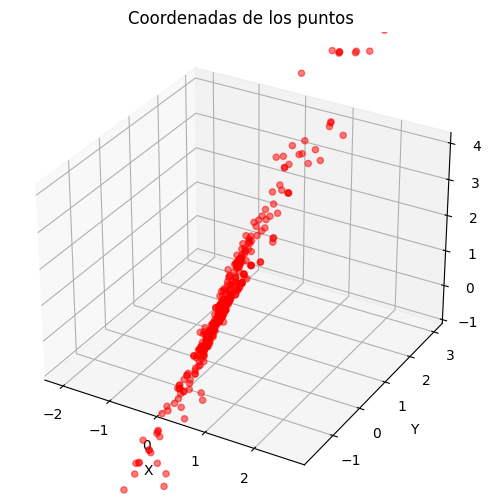

In [9]:
# Visualizar todos los puntos juntos
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Iterar sobre cada conjunto de puntos
for puntos in coordenadas_puntos:
    # Graficar los puntos
    ax.scatter(puntos[:, 0], puntos[:, 1], puntos[:, 2], marker='o', s=20, c='r', alpha=0.5)

# Configurar etiquetas y título
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Coordenadas de los puntos')

# Configurar la relación de aspecto para que los ejes tengan la misma escala
max_range = np.array([np.max(puntos[:,0])-np.min(puntos[:,0]), np.max(puntos[:,1])-np.min(puntos[:,1]), np.max(puntos[:,2])-np.min(puntos[:,2])]).max() / 2.0
mid_x = (np.max(puntos[:,0]) + np.min(puntos[:,0])) * 0.5
mid_y = (np.max(puntos[:,1]) + np.min(puntos[:,1])) * 0.5
mid_z = (np.max(puntos[:,2]) + np.min(puntos[:,2])) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Mostrar la gráfica
plt.show()